# 1. Introduction

In this notebook, the IGANN-IT model is applied to 12 structured data sets and compared with interpretable and non-interpretable baselines.

# 2. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, log_loss, average_precision_score
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from interpret.glassbox import ExplainableBoostingRegressor, ExplainableBoostingClassifier
from pathlib import Path
import importlib
import time

import igann
importlib.reload(igann)
from igann import IGANN

%load_ext autoreload
%autoreload 2

In [2]:
data_path = "/Users/maximilianveitl/data/shared"
seed = 1234

# 3. Overview Datasets

In [3]:
import yaml

with open("/Users/maximilianveitl/workspace/master/datasets-main/datasets.yml", "r") as file:
    data = yaml.safe_load(file)

dataset_rows = []
for name, cfg in data["datasets"].items():
    num_features = cfg.get("numerical_features", [])
    cat_features = cfg.get("categorical_features", [])

    if len(cat_features) >= 1:
        row = {
            "name": name,
            "file_name": cfg.get("file_name"),
            "task_type": cfg.get("task_type"),
            "n_num_features": len(num_features),
            "n_cat_features": len(cat_features),
            "target": cfg.get("target"),
            "separator": cfg.get("separator", ","),
            "folder_name": cfg.get("folder_name", "shared"),
            "num_features": num_features,
            "cat_features": cat_features
        }
        dataset_rows.append(row)
        
df_overview = pd.DataFrame(dataset_rows)

df_overview.head(23)

,name,file_name,task_type,n_num_features,n_cat_features,target,separator,folder_name,num_features,cat_features
0,stroke,healthcare-dataset-stroke-data.csv,binary,3,7,stroke,",",shared,"[age, avg_glucose_level, bmi]","[gender, hypertension, heart_disease, ever_mar..."
1,churn,WA_Fn-UseC_-Telco-Customer-Churn.csv,binary,3,16,Churn,",",shared,"[tenure, MonthlyCharges, TotalCharges]","[gender, SeniorCitizen, Partner, Dependents, P..."
2,fico,fico_heloc_dataset_v1.csv,binary,21,2,RiskPerformance,",",shared,"[ExternalRiskEstimate, MSinceOldestTradeOpen, ...","[MaxDelq2PublicRecLast12M, MaxDelqEver]"
3,bank,bank-full.csv,binary,6,9,y,;,shared,"[age, balance, day, campaign, pdays, previous]","[job, marital, education, default, housing, lo..."
4,adult,adult_census_income.csv,binary,6,8,income,",",shared,"[age, fnlwgt, education.num, capital.gain, cap...","[workclass, education, marital.status, occupat..."
5,airline,airline_train.csv,binary,18,4,satisfaction,",",shared,"[Age, Flight Distance, Inflight wifi service, ...","[Gender, Customer Type, Type of Travel, Class]"
6,college,college_data.csv,binary,4,6,will_go_to_college,",",shared,"[parent_age, parent_salary, house_area, averag...","[type_school, school_accreditation, gender, in..."
7,weather,weatherAUS.csv,binary,16,5,RainTomorrow,",",shared,"[MinTemp, MaxTemp, Rainfall, Evaporation, Suns...","[Location, WindGustDir, WindDir9am, WindDir3pm..."
8,compas,compas-scores-two-years.csv,binary,7,5,two_year_recid,",",shared,"[age, juv_fel_count, juv_misd_count, juv_other...","[sex, age_cat, race, c_charge_degree, c_charge..."
9,car,car.data,regression,13,11,price,",",shared,"[wheel-base, length, width, height, curb-weigh...","[symboling, make, fuel-type, aspiration, num-o..."


In [4]:
# Shape of the datasets
for idx, row in df_overview.iterrows():
    file_path = f"{data_path}/{row['name']}/{row['file_name']}"
    data = pd.read_csv(file_path, sep=row["separator"])
    print(f"Dataset: {row['name']}, Shape: {data.shape}")

Dataset: stroke, Shape: (5110, 12)
Dataset: churn, Shape: (7043, 21)
Dataset: fico, Shape: (10459, 24)
Dataset: bank, Shape: (45211, 17)
Dataset: adult, Shape: (32561, 15)
Dataset: airline, Shape: (103904, 25)
Dataset: college, Shape: (1000, 11)
Dataset: weather, Shape: (145460, 23)
Dataset: compas, Shape: (7214, 53)
Dataset: car, Shape: (201, 26)
Dataset: student, Shape: (649, 33)
Dataset: bike, Shape: (17379, 17)
Dataset: insurance, Shape: (1338, 7)
Dataset: crab, Shape: (3893, 9)
Dataset: diamond, Shape: (53943, 10)
Dataset: productivity, Shape: (1197, 15)
Dataset: diabetes, Shape: (442, 12)


# 4. Evaluation Regression Tasks

In [5]:
results_regression = pd.DataFrame(columns=["model", "dataset", "mse", "r2", "train_duration"])

## 4.1 Lasso and Ridge Regression

In [6]:
# model Lasso and Ridge (one-hot encoding needed)
datasets_filtered = df_overview[(df_overview["task_type"] == "regression") & (df_overview["name"] != "car")]

models = {
    "Lasso": Lasso(random_state=seed),
    "Ridge": Ridge(random_state=seed),
}

for idx, row in datasets_filtered.iterrows():
    # load data
    file_name = row["file_name"]
    separator = row["separator"]
    folder_name = row["name"]
    target = row["target"]
    file_path = f"{data_path}/{folder_name}/{file_name}"

    data = pd.read_csv(file_path, sep=separator)
    
    X = data.drop(columns=target)
    y = data[target]

    # Preprocessing
    # 1. Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    # 2. Split features into numerical and categorical
    X_train_num = X_train[row["num_features"]]
    X_train_cat = X_train[row["cat_features"]]
    X_test_num = X_test[row["num_features"]]
    X_test_cat = X_test[row["cat_features"]]

    # 3. Replace empty strings and other chars in numerical features with np.nan
    X_train_num = X_train_num.replace({"": np.nan, " ": np.nan, "?": np.nan})
    X_test_num = X_test_num.replace({"": np.nan, " ": np.nan, "?": np.nan})

    # 4. Correct data types
    X_train_num = X_train_num.astype(float)
    X_test_num = X_test_num.astype(float)
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)

    # 5. Impute missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_num = imputer_num.fit_transform(X_train_num)
    X_train_cat = imputer_cat.fit_transform(X_train_cat)
    X_test_num = imputer_num.transform(X_test_num)
    X_test_cat = imputer_cat.transform(X_test_cat)

    # 6. Scale numerical features and target and one-hot encode categorical features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean) / y_train_std
    y_test = (y_test - y_train_mean) / y_train_std
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])
    X_train_cat = pd.get_dummies(X_train_cat, drop_first=True)
    X_test_cat = pd.get_dummies(X_test_cat, drop_first=True)
    X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

    # 7. Concatenate numerical and categorical features
    X_train_num = pd.DataFrame(X_train_num, columns=row["num_features"])
    X_test_num = pd.DataFrame(X_test_num, columns=row["num_features"])

    X_train = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test = pd.concat([X_test_num, X_test_cat], axis=1)

    # 8. Train Models
    for name, model in models.items():
        print(f"Training {name} on {folder_name} dataset...")
        model = clone(model)
        start_time = time.time()
        model.fit(X_train, y_train)
        train_duration = time.time() - start_time
        y_pred = model.predict(X_test)

        # 9. Evaluate Models
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results_regression.loc[len(results_regression)] = {
            'model': name,
            'dataset': folder_name,
            'mse': mse,
            'r2': r2,
            'train_duration': train_duration,
        }

Training Lasso on student dataset...
Training Ridge on student dataset...
Training Lasso on bike dataset...
Training Ridge on bike dataset...
Training Lasso on insurance dataset...
Training Ridge on insurance dataset...
Training Lasso on crab dataset...
Training Ridge on crab dataset...
Training Lasso on diamond dataset...
Training Ridge on diamond dataset...
Training Lasso on productivity dataset...
Training Ridge on productivity dataset...
Training Lasso on diabetes dataset...
Training Ridge on diabetes dataset...


## 4.2 Decision Tree and Random Forest

In [7]:
# DecisionTree, RandomForest (OrdinalEncoder needed)
datasets_filtered = df_overview[(df_overview["task_type"] == "regression") & (df_overview["name"] != "car")]

models = {
    "DecisionTree": DecisionTreeRegressor(random_state=seed),
    "RandomForest": RandomForestRegressor(random_state=seed),
}

for idx, row in datasets_filtered.iterrows():
    # load data
    file_name = row["file_name"]
    separator = row["separator"]
    folder_name = row["name"]
    target = row["target"]
    file_path = f"{data_path}/{folder_name}/{file_name}"

    data = pd.read_csv(file_path, sep=separator)
    
    X = data.drop(columns=target)
    y = data[target]

    # Preprocessing
    # 1. Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    # 2. Split features into numerical and categorical
    X_train_num = X_train[row["num_features"]]
    X_train_cat = X_train[row["cat_features"]]
    X_test_num = X_test[row["num_features"]]
    X_test_cat = X_test[row["cat_features"]]

    # 3. Replace empty strings and other chars in numerical features with np.nan
    X_train_num = X_train_num.replace({"": np.nan, " ": np.nan, "?": np.nan})
    X_test_num = X_test_num.replace({"": np.nan, " ": np.nan, "?": np.nan})

    # 4. Correct data types
    X_train_num = X_train_num.astype(float)
    X_test_num = X_test_num.astype(float)
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)

    # 5. Impute missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_num = imputer_num.fit_transform(X_train_num)
    X_train_cat = imputer_cat.fit_transform(X_train_cat)
    X_test_num = imputer_num.transform(X_test_num)
    X_test_cat = imputer_cat.transform(X_test_cat)

    # 6. Scale numerical features and target and ordinal encoding categorical features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean) / y_train_std
    y_test = (y_test - y_train_mean) / y_train_std
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train_cat = encoder.fit_transform(X_train_cat)
    X_test_cat = encoder.transform(X_test_cat)

    # 7. Concatenate numerical and categorical features
    X_train_num = pd.DataFrame(X_train_num, columns=row["num_features"])
    X_test_num = pd.DataFrame(X_test_num, columns=row["num_features"])
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])

    X_train = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test = pd.concat([X_test_num, X_test_cat], axis=1)
        
    # 8. Train Models
    for name, model in models.items():
        print(f"Training {name} on {folder_name} dataset...")
        model = clone(model)
        start_time = time.time()
        model.fit(X_train, y_train)
        train_duration = time.time() - start_time
        y_pred = model.predict(X_test)

        # 9. Evaluate Models
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results_regression.loc[len(results_regression)] = {
            'model': name,
            'dataset': folder_name,
            'mse': mse,
            'r2': r2,
            'train_duration': train_duration,
        }

Training DecisionTree on student dataset...
Training RandomForest on student dataset...
Training DecisionTree on bike dataset...
Training RandomForest on bike dataset...
Training DecisionTree on insurance dataset...
Training RandomForest on insurance dataset...
Training DecisionTree on crab dataset...
Training RandomForest on crab dataset...
Training DecisionTree on diamond dataset...
Training RandomForest on diamond dataset...
Training DecisionTree on productivity dataset...
Training RandomForest on productivity dataset...
Training DecisionTree on diabetes dataset...
Training RandomForest on diabetes dataset...


## 4.3 EBM

In [8]:
# EBM

datasets_filtered = df_overview[(df_overview["task_type"] == "regression") & (df_overview["name"] != "car")]

for idx, row in datasets_filtered.iterrows():
    # load data
    file_name = row["file_name"]
    separator = row["separator"]
    folder_name = row["name"]
    target = row["target"]
    file_path = f"{data_path}/{folder_name}/{file_name}"

    data = pd.read_csv(file_path, sep=separator)
    
    X = data.drop(columns=target)
    y = data[target]

    # Preprocessing
    # 1. Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    # 2. Split features into numerical and categorical
    X_train_num = X_train[row["num_features"]]
    X_train_cat = X_train[row["cat_features"]]
    X_test_num = X_test[row["num_features"]]
    X_test_cat = X_test[row["cat_features"]]

    # 3. Replace empty strings and other chars in numerical features with np.nan
    X_train_num = X_train_num.replace({"": np.nan, " ": np.nan, "?": np.nan})
    X_test_num = X_test_num.replace({"": np.nan, " ": np.nan, "?": np.nan})

    # 4. Correct data types
    X_train_num = X_train_num.astype(float)
    X_test_num = X_test_num.astype(float)
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)

    # 5. Impute missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_num = imputer_num.fit_transform(X_train_num)
    X_train_cat = imputer_cat.fit_transform(X_train_cat)
    X_test_num = imputer_num.transform(X_test_num)
    X_test_cat = imputer_cat.transform(X_test_cat)

    # 6. Scale numerical features and target and one-hot encode categorical features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean) / y_train_std
    y_test = (y_test - y_train_mean) / y_train_std

    # 7. Concatenate numerical and categorical features
    X_train_num = pd.DataFrame(X_train_num, columns=row["num_features"])
    X_test_num = pd.DataFrame(X_test_num, columns=row["num_features"])
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])

    X_train = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test = pd.concat([X_test_num, X_test_cat], axis=1)

    # 8. Train Model
    model = ExplainableBoostingRegressor(interactions=1)
    print(f"Training EBM on {folder_name} dataset...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_duration = time.time() - start_time
    y_pred = model.predict(X_test)

    # 9. Evaluate Model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results_regression.loc[len(results_regression)] = {
        'model': 'EBM',
        'dataset': folder_name,
        'mse': mse,
        'r2': r2,
        'train_duration': train_duration}

Training EBM on student dataset...
Training EBM on bike dataset...
Training EBM on insurance dataset...
Training EBM on crab dataset...
Training EBM on diamond dataset...
Training EBM on productivity dataset...
Training EBM on diabetes dataset...


## 4.4 IGANN

In [9]:
# IGANN

datasets_filtered = df_overview[(df_overview["task_type"] == "regression") & (df_overview["name"] != "car")]
#datasets_filtered = df_overview[(df_overview["name"] == "diamond")]

for idx, row in datasets_filtered.iterrows():
    # load data
    file_name = row["file_name"]
    separator = row["separator"]
    folder_name = row["name"]
    target = row["target"]
    file_path = f"{data_path}/{folder_name}/{file_name}"

    data = pd.read_csv(file_path, sep=separator)
    
    X = data.drop(columns=target)
    y = data[target]

    # Preprocessing
    # 1. Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    # 2. Split features into numerical and categorical
    X_train_num = X_train[row["num_features"]]
    X_train_cat = X_train[row["cat_features"]]
    X_test_num = X_test[row["num_features"]]
    X_test_cat = X_test[row["cat_features"]]

    # 3. Replace empty strings and other chars in numerical features with np.nan
    X_train_num = X_train_num.replace({"": np.nan, " ": np.nan, "?": np.nan})
    X_test_num = X_test_num.replace({"": np.nan, " ": np.nan, "?": np.nan})

    # 4. Correct data types
    X_train_num = X_train_num.astype(float)
    X_test_num = X_test_num.astype(float)
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)

    # 5. Impute missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_num = imputer_num.fit_transform(X_train_num)
    X_train_cat = imputer_cat.fit_transform(X_train_cat)
    X_test_num = imputer_num.transform(X_test_num)
    X_test_cat = imputer_cat.transform(X_test_cat)

    # 6. Scale numerical features and target and one-hot encode categorical features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean) / y_train_std
    y_test = (y_test - y_train_mean) / y_train_std

    # 7. Concatenate numerical and categorical features
    X_train_num = pd.DataFrame(X_train_num, columns=row["num_features"])
    X_test_num = pd.DataFrame(X_test_num, columns=row["num_features"])
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])

    X_train = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test = pd.concat([X_test_num, X_test_cat], axis=1)

    # 8. Train Model
    print(f"Training IGANN on {folder_name} dataset...")
    model = IGANN(task="regression", n_hid=10, igann_it=False)
    start_time = time.time()
    model.fit(X_train, y_train)
    train_duration = time.time() - start_time
    y_pred = model.predict(X_test)

    # 9. Evaluate Model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results_regression.loc[len(results_regression)] = {
        'model': 'IGANN',
        'dataset': folder_name,
        'mse': mse,
        'r2': r2,
        'train_duration': train_duration}
    
    # Check overfitting
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    print(f"Train MSE: {mse_train}")
    print(f"Test MSE: {mse}")

Training IGANN on student dataset...
Train MSE: 0.652182475833646
Test MSE: 0.866680699236681
Training IGANN on bike dataset...
Train MSE: 0.40484460910423925
Test MSE: 0.4011842566744653
Training IGANN on insurance dataset...
Train MSE: 0.24846687498642128
Test MSE: 0.25430675920279
Training IGANN on crab dataset...
Train MSE: 0.4376464306206222
Test MSE: 0.47460306824168763
Training IGANN on diamond dataset...
Train MSE: 0.06861307688176076
Test MSE: 0.0728808811330158
Training IGANN on productivity dataset...
Train MSE: 0.7054109617448154
Test MSE: 0.6789582406257573
Training IGANN on diabetes dataset...
Train MSE: 0.4268973656763846
Test MSE: 0.4865429028151774


## 4.5 IGANN-IT

In [10]:
# IGANN-IT

datasets_filtered = df_overview[(df_overview["task_type"] == "regression") & (df_overview["name"] != "car")]
#datasets_filtered = df_overview[(df_overview["name"] == "insurance")]


for idx, row in datasets_filtered.iterrows():
    # load data
    file_name = row["file_name"]
    separator = row["separator"]
    folder_name = row["name"]
    target = row["target"]
    file_path = f"{data_path}/{folder_name}/{file_name}"

    data = pd.read_csv(file_path, sep=separator)
    
    X = data.drop(columns=target)
    y = data[target]

    # Preprocessing
    # 1. Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    # 2. Split features into numerical and categorical
    X_train_num = X_train[row["num_features"]]
    X_train_cat = X_train[row["cat_features"]]
    X_test_num = X_test[row["num_features"]]
    X_test_cat = X_test[row["cat_features"]]

    # 3. Replace empty strings and other chars in numerical features with np.nan
    X_train_num = X_train_num.replace({"": np.nan, " ": np.nan, "?": np.nan})
    X_test_num = X_test_num.replace({"": np.nan, " ": np.nan, "?": np.nan})

    # 4. Correct data types
    X_train_num = X_train_num.astype(float)
    X_test_num = X_test_num.astype(float)
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)

    # 5. Impute missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_num = imputer_num.fit_transform(X_train_num)
    X_train_cat = imputer_cat.fit_transform(X_train_cat)
    X_test_num = imputer_num.transform(X_test_num)
    X_test_cat = imputer_cat.transform(X_test_cat)

    # 6. Scale numerical features and target and one-hot encode categorical features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean) / y_train_std
    y_test = (y_test - y_train_mean) / y_train_std

    # 7. Concatenate numerical and categorical features
    X_train_num = pd.DataFrame(X_train_num, columns=row["num_features"])
    X_test_num = pd.DataFrame(X_test_num, columns=row["num_features"])
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])

    X_train = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test = pd.concat([X_test_num, X_test_cat], axis=1)

    # 8. Train Model
    print(f"Training IGANN on {folder_name} dataset...")
    model = IGANN(task="regression", n_hid=10, interaction_detection_method="rulefit")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_duration = time.time() - start_time
    y_pred = model.predict(X_test)

    # 9. Evaluate Model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results_regression.loc[len(results_regression)] = {
        'model': 'IGANN-IT',
        'dataset': folder_name,
        'mse': mse,
        'r2': r2,
        'train_duration': train_duration}
    print(f"Train MSE: {mse_train}")
    print(f"Test MSE: {mse}")

Training IGANN on student dataset...
No feature combination found. Model does not capture interactions. Try different feature interaction detection method.
Train MSE: 0.4268973656763846
Test MSE: 0.866680699236681
Training IGANN on bike dataset...
Train MSE: 0.4268973656763846
Test MSE: 0.3761116940519323
Training IGANN on insurance dataset...
Train MSE: 0.4268973656763846
Test MSE: 0.14653984751745452
Training IGANN on crab dataset...
Train MSE: 0.4268973656763846
Test MSE: 0.47243791344183256
Training IGANN on diamond dataset...
Train MSE: 0.4268973656763846
Test MSE: 0.06181883697069438
Training IGANN on productivity dataset...
Train MSE: 0.4268973656763846
Test MSE: 0.6789582406257573
Training IGANN on diabetes dataset...
Train MSE: 0.4268973656763846
Test MSE: 0.4865429028151774


## 4.5 Results Regression Tasks

In [11]:
def create_metric_df(metric):
    pivot_df = results_regression.pivot_table(index='model', columns='dataset', values=metric)
    pivot_df['mean'] = pivot_df.mean(axis=1)
    pivot_df = pivot_df[['mean'] + [col for col in pivot_df.columns if col != 'mean']]
    return pivot_df

mse_df = create_metric_df('mse')
r2_df = create_metric_df('r2')
train_time_df = create_metric_df('train_duration')

### 4.5.1 MSE

In [12]:
# reorder columns
mse_df = mse_df[['mean', 'diabetes', 'student', 'insurance', 'productivity', 'crab', 'bike', 'diamond']]
mse_df.columns = ['Mean', 'diab', 'stud', 'insur', 'prod', 'crab', 'bike', 'diam']

# reorder rows by index
mse_df = mse_df.reindex(['Lasso', 'Ridge', 'DecisionTree', 'EBM', 'IGANN', 'IGANN-IT', 'RandomForest'])

round(mse_df, 2)

,Mean,diab,stud,insur,prod,crab,bike,diam
model,,,,,,,,
Lasso,1.05,0.92,1.25,0.96,1.13,1.09,1.00,0.98
Ridge,0.49,0.49,0.83,0.25,0.68,0.51,0.60,0.08
DecisionTree,0.72,1.03,1.50,0.26,1.19,0.91,0.11,0.04
EBM,0.38,0.49,0.82,0.13,0.54,0.46,0.17,0.04
IGANN,0.46,0.49,0.87,0.25,0.68,0.47,0.40,0.07
IGANN-IT,0.44,0.49,0.87,0.15,0.68,0.47,0.38,0.06
RandomForest,0.37,0.53,0.80,0.15,0.54,0.48,0.06,0.02


In [13]:
mse_ranking = mse_df.iloc[:, 1:].rank(axis=0, method='min', ascending=True)

mse_ranking['mean_rank'] = mse_ranking.mean(axis=1)
mse_ranking['median_rank'] = mse_ranking.iloc[:, :7].median(axis=1)

mse_ranking

,diab,stud,insur,prod,crab,bike,diam,mean_rank,median_rank
model,,,,,,,,,
Lasso,6.0,6.0,7.0,6.0,7.0,7.0,7.0,6.571429,7.0
Ridge,1.0,3.0,4.0,5.0,5.0,6.0,6.0,4.285714,5.0
DecisionTree,7.0,7.0,6.0,7.0,6.0,2.0,2.0,5.285714,6.0
EBM,4.0,2.0,1.0,2.0,1.0,3.0,3.0,2.285714,2.0
IGANN,2.0,4.0,5.0,3.0,3.0,5.0,5.0,3.857143,4.0
IGANN-IT,2.0,4.0,2.0,3.0,2.0,4.0,4.0,3.000000,3.0
RandomForest,5.0,1.0,3.0,1.0,4.0,1.0,1.0,2.285714,1.0


In [14]:
" (" + mse_ranking.round(0).astype(int).astype(str) + ")"

,diab,stud,insur,prod,crab,bike,diam,mean_rank,median_rank
model,,,,,,,,,
Lasso,(6),(6),(7),(6),(7),(7),(7),(7),(7)
Ridge,(1),(3),(4),(5),(5),(6),(6),(4),(5)
DecisionTree,(7),(7),(6),(7),(6),(2),(2),(5),(6)
EBM,(4),(2),(1),(2),(1),(3),(3),(2),(2)
IGANN,(2),(4),(5),(3),(3),(5),(5),(4),(4)
IGANN-IT,(2),(4),(2),(3),(2),(4),(4),(3),(3)
RandomForest,(5),(1),(3),(1),(4),(1),(1),(2),(1)


### 4.5.2 H1 Hypothesis Testing

In [15]:
from scipy.stats import wilcoxon
import numpy as np

mse_df_trans = mse_df.T

# effect size
diffs = mse_df_trans['IGANN-IT'] - mse_df_trans['IGANN']
non_zero_diffs = diffs[diffs != 0]
n_pos = (non_zero_diffs < 0).sum()  # IGANN-IT besser
n_neg = (non_zero_diffs > 0).sum()  # IGANN besser
n = len(non_zero_diffs)
# rank-biserial correlation
r_b = (n_pos - n_neg) / n

# Wilcoxon signed-rank test
stat, p_value = wilcoxon(mse_df_trans['IGANN-IT'], mse_df_trans['IGANN'], alternative='less')

# Ergebnisse ausgeben
print("Hypothesentest: IGANN-IT vs. IGANN (ungekorrigiert)")
print(f"Teststatistik = {stat:.4f}")
print(f"p-Wert = {p_value:.4f}")
print(f"Rank-biserial correlation r_b = {r_b:.4f}")

if p_value < 0.05:
    print("Ergebnis: Signifikanter Unterschied zugunsten von IGANN-IT (α = 0.05)")
else:
    print("Ergebnis: Kein signifikanter Unterschied (α = 0.05)")


Hypothesentest: IGANN-IT vs. IGANN (ungekorrigiert)
Teststatistik = 0.0000
p-Wert = 0.0216
Rank-biserial correlation r_b = 1.0000
Ergebnis: Signifikanter Unterschied zugunsten von IGANN-IT (α = 0.05)


/Users/maximilianveitl/opt/anaconda3/envs/maenv/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


In [16]:
from scipy.stats import friedmanchisquare

reg_stat, reg_p = friedmanchisquare(*[mse_df_trans[model] for model in mse_df_trans.columns])
print("Friedman-Test (Regression):")
print(f"Teststatistik = {reg_stat:.3f}, p-Wert = {reg_p:.4f}\n")

Friedman-Test (Regression):
Teststatistik = 27.897, p-Wert = 0.0001



In [17]:
from statsmodels.stats.multitest import multipletests

ref_model = "IGANN-IT"
p_values = []
comparisons = []

for model in mse_df_trans.columns:
    if model != ref_model:
        stat, p = wilcoxon(mse_df_trans[ref_model], mse_df_trans[model])
        p_values.append(p)
        comparisons.append(model)

# Holm-Korrektur
rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')

# Ergebnisse als DataFrame
holm_results = pd.DataFrame({
    "Modell": comparisons,
    "p-Wert (ungekorrigiert)": p_values,
    "p-Wert (Holm-korrigiert)": pvals_corrected,
    "Signifikant (α = 0.05)": rejected
})

print("Explorative Tests: IGANN-IT vs. andere Modelle (Holm-korrigiert)")
print(holm_results)


Explorative Tests: IGANN-IT vs. andere Modelle (Holm-korrigiert)
         Modell  p-Wert (ungekorrigiert)  p-Wert (Holm-korrigiert)  \
0         Lasso                 0.007812                  0.046875   
1         Ridge                 0.109375                  0.218750   
2  DecisionTree                 0.054688                  0.172458   
3           EBM                 0.015625                  0.078125   
4         IGANN                 0.043114                  0.172458   
5  RandomForest                 0.109375                  0.218750   

   Signifikant (α = 0.05)  
0                    True  
1                   False  
2                   False  
3                   False  
4                   False  
5                   False  


### 4.5.3 R2

In [18]:
# reorder columns
r2_df = r2_df[['mean', 'diabetes', 'student', 'insurance', 'productivity', 'crab', 'bike', 'diamond']]
r2_df.columns = ['Mean', 'diab', 'stud', 'insur', 'prod', 'crab', 'bike', 'diam']

# reorder rows by index
r2_df = r2_df.reindex(['Lasso', 'Ridge', 'DecisionTree', 'EBM', 'IGANN', 'IGANN-IT', 'RandomForest'])

round(r2_df, 3)

,Mean,diab,stud,insur,prod,crab,bike,diam
model,,,,,,,,
Lasso,-0.007,-0.001,-0.032,-0.000,-0.011,-0.000,-0.001,-0.000
Ridge,0.538,0.471,0.319,0.741,0.388,0.537,0.394,0.918
DecisionTree,0.334,-0.116,-0.241,0.728,-0.065,0.170,0.895,0.963
EBM,0.648,0.471,0.326,0.863,0.512,0.577,0.828,0.958
IGANN,0.567,0.471,0.285,0.735,0.390,0.565,0.597,0.926
IGANN-IT,0.589,0.471,0.285,0.847,0.390,0.567,0.622,0.937
RandomForest,0.658,0.427,0.337,0.840,0.515,0.562,0.945,0.982


In [19]:
" (" + r2_df.iloc[:, 1:].rank(axis=0, method='min', ascending=False).round(0).astype(int).astype(str) + ")"

,diab,stud,insur,prod,crab,bike,diam
model,,,,,,,
Lasso,(6),(6),(7),(6),(7),(7),(7)
Ridge,(1),(3),(4),(5),(5),(6),(6)
DecisionTree,(7),(7),(6),(7),(6),(2),(2)
EBM,(4),(2),(1),(2),(1),(3),(3)
IGANN,(2),(4),(5),(3),(3),(5),(5)
IGANN-IT,(2),(4),(2),(3),(2),(4),(4)
RandomForest,(5),(1),(3),(1),(4),(1),(1)


In [20]:
# dataframe with rows as models and columns: MSE, STD, Mean Rank, Median Rank, W/L, R2, STD, Mean Rank, Median Rank, W/L, Train Time, STD, Mean Rank, Median Rank, W/L
results_summary = pd.DataFrame(index=['Lasso', 'Ridge', 'DecisionTree', 'EBM', 'IGANN', 'IGANN-IT', 'RandomForest'])
results_summary['MSE'] = mse_df['Mean']
results_summary['MSE_STD'] = mse_df.iloc[:, 1:].std(axis=1)
results_summary['MSE_Mean_Rank'] = mse_ranking['mean_rank']
results_summary['MSE_Median_Rank'] = mse_ranking['median_rank']
mse_cols = ['diab', 'stud', 'insur', 'prod', 'crab', 'bike', 'diam']
ref = mse_df.loc['IGANN-IT', mse_cols]
results_summary['MSE_W/L']=(mse_df[mse_cols] < ref).sum(axis=1).astype(str) + '/' + (mse_df[mse_cols] > ref).sum(axis=1).astype(str)

results_summary['R2'] = r2_df['Mean']
results_summary['R2_STD'] = r2_df.iloc[:, 1:].std(axis=1)
results_summary['R2_Mean_Rank'] = r2_df.iloc[:, 1:].rank(axis=0, method='min', ascending=False).mean(axis=1)
results_summary['R2_Median_Rank'] = r2_df.iloc[:, 1:].rank(axis=0, method='min', ascending=False).median(axis=1)
ref = r2_df.loc['IGANN-IT', mse_cols]
results_summary['R2_W/L']=(r2_df[mse_cols] > ref).sum(axis=1).astype(str) + '/' + (r2_df[mse_cols] < ref).sum(axis=1).astype(str)

results_summary


,MSE,MSE_STD,MSE_Mean_Rank,MSE_Median_Rank,MSE_W/L,R2,R2_STD,R2_Mean_Rank,R2_Median_Rank,R2_W/L
Lasso,1.047059,0.115499,6.571429,7.0,0/7,-0.006589,0.012006,6.571429,7.0,0/7
Ridge,0.490070,0.254412,4.285714,5.0,2/5,0.538364,0.216583,4.285714,5.0,2/5
DecisionTree,0.717633,0.579668,5.285714,6.0,2/5,0.333513,0.513763,5.285714,6.0,2/5
EBM,0.378790,0.275501,2.285714,2.0,6/1,0.647985,0.235566,2.285714,2.0,6/1
IGANN,0.462165,0.261358,3.857143,4.0,0/4,0.567004,0.215209,3.857143,4.0,0/4
IGANN-IT,0.441299,0.281539,3.000000,3.0,0/0,0.588558,0.236404,3.000000,3.0,0/0
RandomForest,0.367797,0.295434,2.285714,1.0,4/3,0.658289,0.260296,2.285714,1.0,4/3


### 4.5.4 Train Time

In [21]:
# reorder columns
train_time_df = train_time_df[['mean', 'diabetes', 'student', 'insurance', 'productivity', 'crab', 'bike', 'diamond']]
train_time_df.columns = ['Mean', 'diab', 'stud', 'insur', 'prod', 'crab', 'bike', 'diam']

# reorder rows by index
train_time_df = train_time_df.reindex(['Lasso', 'Ridge', 'DecisionTree', 'EBM', 'IGANN', 'IGANN-IT', 'RandomForest'])

train_time_df[['diab', 'stud', 'insur', 'prod', 'crab', 'bike', 'diam','Mean']].round(4)

,diab,stud,insur,prod,crab,bike,diam,Mean
model,,,,,,,,
Lasso,0.0034,0.0040,0.0042,0.0043,0.0055,0.0122,0.0402,0.0105
Ridge,0.0023,0.0025,0.0027,0.0031,0.0038,0.0041,0.0134,0.0046
DecisionTree,0.0046,0.0055,0.0055,0.0080,0.0236,0.0776,0.2708,0.0565
EBM,1.7675,11.1506,1.1462,3.4352,6.5670,15.0078,37.2633,10.9054
IGANN,2.0417,0.1625,2.1916,0.1460,0.3148,12.7831,20.9891,5.5184
IGANN-IT,1.9824,0.8431,5.3735,0.5972,1.2039,20.6704,38.6812,9.9074
RandomForest,0.2783,0.4432,0.3334,0.4476,1.5693,5.0850,18.1072,3.7520


In [22]:
" (" + train_time_df.iloc[:, 1:].rank(axis=0, method='min', ascending=True).round(0).astype(int).astype(str) + ")"

,diab,stud,insur,prod,crab,bike,diam
model,,,,,,,
Lasso,(2),(2),(2),(2),(2),(2),(2)
Ridge,(1),(1),(1),(1),(1),(1),(1)
DecisionTree,(3),(3),(3),(3),(3),(3),(3)
EBM,(5),(7),(5),(7),(7),(6),(6)
IGANN,(7),(4),(6),(4),(4),(5),(5)
IGANN-IT,(6),(6),(7),(6),(5),(7),(7)
RandomForest,(4),(5),(4),(5),(6),(4),(4)


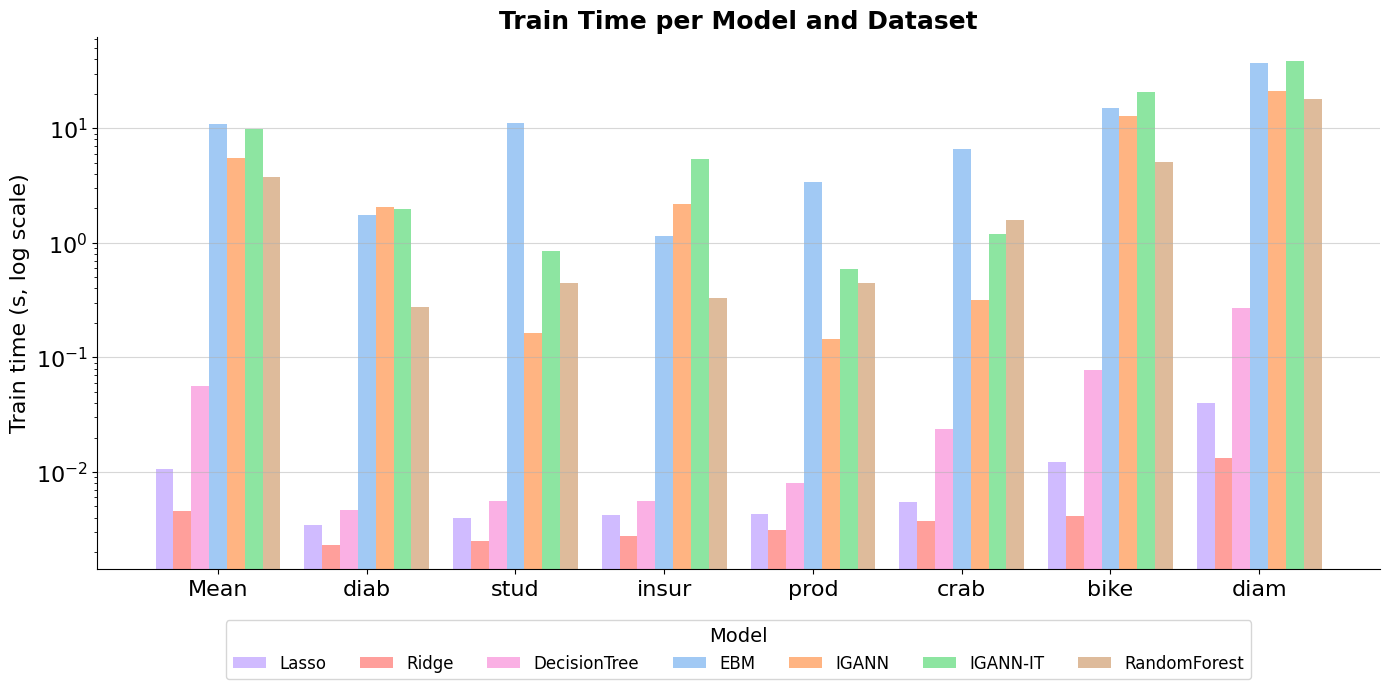

In [23]:
# Use seaborn pastel palette
#pastel_colors = sns.color_palette("pastel", len(train_time_df.index))
custom_colors = {
    'Lasso': '#d0bbff',
    'Ridge': '#ff9f9b',
    'DecisionTree': '#fab0e4',
    'EBM': '#a1c9f4',
    'IGANN': '#ffb482',
    'IGANN-IT': '#8de5a1',
    'RandomForest': '#debb9b'
}
bar_width = 0.12
x = np.arange(len(train_time_df.columns)) 

# Plot setup with pastel colors
fig, ax = plt.subplots(figsize=(14, 7))

# Plot each model's bars using pastel colors
for i, model in enumerate(train_time_df.index):
    times = train_time_df.loc[model]
    ax.bar(x + i * bar_width, times, width=bar_width, label=model, color=custom_colors[model])

# Axes and formatting
ax.set_yscale("log")
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Train time (s, log scale)", fontsize=16)
ax.set_xticks(x + bar_width * (len(train_time_df.index) - 1) / 2)
ax.set_xticklabels(train_time_df.columns, fontsize=16)
ax.set_title("Train Time per Model and Dataset", fontsize=18, fontweight='semibold')
ax.legend(
    title="Model",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.08),  # x=0.5 → zentriert, y negativ → unterhalb
    ncol=len(train_time_df.index),      # alle Einträge in einer Zeile
    frameon=True,
    fontsize=12,
    title_fontsize=14,
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, axis='y', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

# 5. Evaluation Classification Tasks

In [24]:
datasets_filtered = df_overview[(df_overview["task_type"] == "binary") & (df_overview["name"] != "adult") & (df_overview["name"] != "airline") & (df_overview["name"] != "weather") & (df_overview["name"] != "compas")]

for idx, row in datasets_filtered.iterrows():
    file_path = f"{data_path}/{row['name']}/{row['file_name']}"
    data = pd.read_csv(file_path, sep=row["separator"])

    print(f"\nDataset: {row['name']}, Shape: {data.shape}")
    print(data[row["target"]].value_counts())


Dataset: stroke, Shape: (5110, 12)
stroke
0    4861
1     249
Name: count, dtype: int64

Dataset: churn, Shape: (7043, 21)
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Dataset: fico, Shape: (10459, 24)
RiskPerformance
Bad     5459
Good    5000
Name: count, dtype: int64

Dataset: bank, Shape: (45211, 17)
y
no     39922
yes     5289
Name: count, dtype: int64

Dataset: college, Shape: (1000, 11)
will_go_to_college
True     500
False    500
Name: count, dtype: int64


In [25]:
results_classification = pd.DataFrame(columns=["model", "dataset", "log_loss", "pr_auc", "train_duration"])

## 5.1 Logistic Regression (L1 and L2)

In [26]:
# Logistic Regression with L1 and L2 regularization (one-hot encoding needed)
datasets_filtered = df_overview[(df_overview["task_type"] == "binary") & (df_overview["name"] != "adult") & (df_overview["name"] != "airline") & (df_overview["name"] != "weather") & (df_overview["name"] != "compas")]

models = {
    "LogisticRegression_L1": LogisticRegression(penalty='l1', solver='liblinear', random_state=seed),
    "LogisticRegression_L2": LogisticRegression(penalty='l2', random_state=seed),
}

for idx, row in datasets_filtered.iterrows():
    # load data
    file_name = row["file_name"]
    separator = row["separator"]
    folder_name = row["name"]
    target = row["target"]
    file_path = f"{data_path}/{folder_name}/{file_name}"

    data = pd.read_csv(file_path, sep=separator)
    
    X = data.drop(columns=target)
    y = data[target]

    # Preprocessing
    # 1. Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    # 2. Split features into numerical and categorical
    X_train_num = X_train[row["num_features"]]
    X_train_cat = X_train[row["cat_features"]]
    X_test_num = X_test[row["num_features"]]
    X_test_cat = X_test[row["cat_features"]]

    # 3. Replace empty strings and other chars in numerical features with np.nan
    X_train_num = X_train_num.replace({"": np.nan, " ": np.nan, "?": np.nan})
    X_test_num = X_test_num.replace({"": np.nan, " ": np.nan, "?": np.nan})

    # 4. Correct data types
    X_train_num = X_train_num.astype(float)
    X_test_num = X_test_num.astype(float)
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)

    # 5. Impute missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_num = imputer_num.fit_transform(X_train_num)
    X_train_cat = imputer_cat.fit_transform(X_train_cat)
    X_test_num = imputer_num.transform(X_test_num)
    X_test_cat = imputer_cat.transform(X_test_cat)

    # 6. Scale numerical features and target and one-hot encode categorical features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])
    X_train_cat = pd.get_dummies(X_train_cat, drop_first=True)
    X_test_cat = pd.get_dummies(X_test_cat, drop_first=True)
    X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

    # 7. Concatenate numerical and categorical features
    X_train_num = pd.DataFrame(X_train_num, columns=row["num_features"])
    X_test_num = pd.DataFrame(X_test_num, columns=row["num_features"])

    X_train = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test = pd.concat([X_test_num, X_test_cat], axis=1)

    # 9. y_train and y_test to 0 and 1
    minority_class = y_train.value_counts().idxmin()
    y_train = (y_train == minority_class).astype(int)
    y_test = (y_test == minority_class).astype(int)

    # 9. Train Models
    for name, model in models.items():
        print(f"Training {name} on {folder_name} dataset...")
        model = clone(model)
        start_time = time.time()
        model.fit(X_train, y_train)
        train_duration = time.time() - start_time
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # 10. Evaluate Models
        logloss = log_loss(y_test, y_pred_proba)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        results_classification.loc[len(results_classification)] = {
            'model': name,
            'dataset': folder_name,
            'log_loss': logloss,
            'pr_auc': pr_auc,
            'train_duration': train_duration,
        }

Training LogisticRegression_L1 on stroke dataset...
Training LogisticRegression_L2 on stroke dataset...
Training LogisticRegression_L1 on churn dataset...
Training LogisticRegression_L2 on churn dataset...
Training LogisticRegression_L1 on fico dataset...
Training LogisticRegression_L2 on fico dataset...


/Users/maximilianveitl/opt/anaconda3/envs/maenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training LogisticRegression_L1 on bank dataset...
Training LogisticRegression_L2 on bank dataset...
Training LogisticRegression_L1 on college dataset...
Training LogisticRegression_L2 on college dataset...


## 5.2 Decision Tree and Random Forest

In [27]:
# Decision Tree and Random Forest (one-hot encoding needed)
datasets_filtered = df_overview[(df_overview["task_type"] == "binary") & (df_overview["name"] != "adult") & (df_overview["name"] != "airline") & (df_overview["name"] != "weather") & (df_overview["name"] != "compas")]

models = {
    "DecisionTree": DecisionTreeClassifier(random_state=seed),
    "RandomForest": RandomForestClassifier(random_state=seed),
}

for idx, row in datasets_filtered.iterrows():
    # load data
    file_name = row["file_name"]
    separator = row["separator"]
    folder_name = row["name"]
    target = row["target"]
    file_path = f"{data_path}/{folder_name}/{file_name}"

    data = pd.read_csv(file_path, sep=separator)
    
    X = data.drop(columns=target)
    y = data[target]

    # Preprocessing
    # 1. Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    # 2. Split features into numerical and categorical
    X_train_num = X_train[row["num_features"]]
    X_train_cat = X_train[row["cat_features"]]
    X_test_num = X_test[row["num_features"]]
    X_test_cat = X_test[row["cat_features"]]

    # 3. Replace empty strings and other chars in numerical features with np.nan
    X_train_num = X_train_num.replace({"": np.nan, " ": np.nan, "?": np.nan})
    X_test_num = X_test_num.replace({"": np.nan, " ": np.nan, "?": np.nan})

    # 4. Correct data types
    X_train_num = X_train_num.astype(float)
    X_test_num = X_test_num.astype(float)
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)

    # 5. Impute missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_num = imputer_num.fit_transform(X_train_num)
    X_train_cat = imputer_cat.fit_transform(X_train_cat)
    X_test_num = imputer_num.transform(X_test_num)
    X_test_cat = imputer_cat.transform(X_test_cat)

    # 6. Scale numerical features and target and one-hot encode categorical features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train_cat = encoder.fit_transform(X_train_cat)
    X_test_cat = encoder.transform(X_test_cat)

    # 7. Concatenate numerical and categorical features
    X_train_num = pd.DataFrame(X_train_num, columns=row["num_features"])
    X_test_num = pd.DataFrame(X_test_num, columns=row["num_features"])
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])

    X_train = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test = pd.concat([X_test_num, X_test_cat], axis=1)

    # 9. y_train and y_test to 0 and 1
    minority_class = y_train.value_counts().idxmin()
    y_train = (y_train == minority_class).astype(int)
    y_test = (y_test == minority_class).astype(int)

    # 9. Train Models
    for name, model in models.items():
        print(f"Training {name} on {folder_name} dataset...")
        model = clone(model)
        start_time = time.time()
        model.fit(X_train, y_train)
        train_duration = time.time() - start_time
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # 10. Evaluate Models
        logloss = log_loss(y_test, y_pred_proba)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        results_classification.loc[len(results_classification)] = {
            'model': name,
            'dataset': folder_name,
            'log_loss': logloss,
            'pr_auc': pr_auc,
            'train_duration': train_duration,
        }

Training DecisionTree on stroke dataset...
Training RandomForest on stroke dataset...
Training DecisionTree on churn dataset...
Training RandomForest on churn dataset...
Training DecisionTree on fico dataset...
Training RandomForest on fico dataset...
Training DecisionTree on bank dataset...
Training RandomForest on bank dataset...
Training DecisionTree on college dataset...
Training RandomForest on college dataset...


## 5.3  EBM

In [28]:
# EBM
datasets_filtered = df_overview[(df_overview["task_type"] == "binary") & (df_overview["name"] != "adult") & (df_overview["name"] != "airline") & (df_overview["name"] != "weather") & (df_overview["name"] != "compas")]

for idx, row in datasets_filtered.iterrows():
    # load data
    file_name = row["file_name"]
    separator = row["separator"]
    folder_name = row["name"]
    target = row["target"]
    file_path = f"{data_path}/{folder_name}/{file_name}"

    data = pd.read_csv(file_path, sep=separator)
    
    X = data.drop(columns=target)
    y = data[target]

    # Preprocessing
    # 1. Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    # 2. Split features into numerical and categorical
    X_train_num = X_train[row["num_features"]]
    X_train_cat = X_train[row["cat_features"]]
    X_test_num = X_test[row["num_features"]]
    X_test_cat = X_test[row["cat_features"]]

    # 3. Replace empty strings and other chars in numerical features with np.nan
    X_train_num = X_train_num.replace({"": np.nan, " ": np.nan, "?": np.nan})
    X_test_num = X_test_num.replace({"": np.nan, " ": np.nan, "?": np.nan})

    # 4. Correct data types
    X_train_num = X_train_num.astype(float)
    X_test_num = X_test_num.astype(float)
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)

    # 5. Impute missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_num = imputer_num.fit_transform(X_train_num)
    X_train_cat = imputer_cat.fit_transform(X_train_cat)
    X_test_num = imputer_num.transform(X_test_num)
    X_test_cat = imputer_cat.transform(X_test_cat)

    # 6. Scale numerical features and target and one-hot encode categorical features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

    # 7. Concatenate numerical and categorical features
    X_train_num = pd.DataFrame(X_train_num, columns=row["num_features"])
    X_test_num = pd.DataFrame(X_test_num, columns=row["num_features"])
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])

    X_train = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test = pd.concat([X_test_num, X_test_cat], axis=1)

    # 9. y_train and y_test to 0 and 1
    minority_class = y_train.value_counts().idxmin()
    y_train = (y_train == minority_class).astype(int)
    y_test = (y_test == minority_class).astype(int)

    # 9. Train Models
    model = ExplainableBoostingClassifier(interactions=1, random_state=seed)
    print(f"Training EBM on {folder_name} dataset...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_duration = time.time() - start_time
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 10. Evaluate Models
    logloss = log_loss(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    results_classification.loc[len(results_classification)] = {
        'model': 'EBM',
        'dataset': folder_name,
        'log_loss': logloss,
        'pr_auc': pr_auc,
        'train_duration': train_duration}

Training EBM on stroke dataset...
Training EBM on churn dataset...
Training EBM on fico dataset...
Training EBM on bank dataset...
Training EBM on college dataset...


## 5.4 IGANN

In [29]:
# IGANN
datasets_filtered = df_overview[(df_overview["task_type"] == "binary") & (df_overview["name"] != "adult") & (df_overview["name"] != "airline") & (df_overview["name"] != "weather") & (df_overview["name"] != "compas")]

for idx, row in datasets_filtered.iterrows():
    # load data
    file_name = row["file_name"]
    separator = row["separator"]
    folder_name = row["name"]
    target = row["target"]
    file_path = f"{data_path}/{folder_name}/{file_name}"

    data = pd.read_csv(file_path, sep=separator)
    
    X = data.drop(columns=target)
    y = data[target]

    # Preprocessing
    # 1. Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    # 2. Split features into numerical and categorical
    X_train_num = X_train[row["num_features"]]
    X_train_cat = X_train[row["cat_features"]]
    X_test_num = X_test[row["num_features"]]
    X_test_cat = X_test[row["cat_features"]]

    # 3. Replace empty strings and other chars in numerical features with np.nan
    X_train_num = X_train_num.replace({"": np.nan, " ": np.nan, "?": np.nan})
    X_test_num = X_test_num.replace({"": np.nan, " ": np.nan, "?": np.nan})

    # 4. Correct data types
    X_train_num = X_train_num.astype(float)
    X_test_num = X_test_num.astype(float)
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)

    # 5. Impute missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_num = imputer_num.fit_transform(X_train_num)
    X_train_cat = imputer_cat.fit_transform(X_train_cat)
    X_test_num = imputer_num.transform(X_test_num)
    X_test_cat = imputer_cat.transform(X_test_cat)

    # 6. Scale numerical features and target and one-hot encode categorical features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

    # 7. Concatenate numerical and categorical features
    X_train_num = pd.DataFrame(X_train_num, columns=row["num_features"])
    X_test_num = pd.DataFrame(X_test_num, columns=row["num_features"])
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])

    X_train = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test = pd.concat([X_test_num, X_test_cat], axis=1)

    # 9. y_train and y_test to 0 and 1
    minority_class = y_train.value_counts().idxmin()
    y_train = (y_train == minority_class).astype(int)
    y_test = (y_test == minority_class).astype(int)

    # 9. Train Models
    model = IGANN(task="classification", n_hid=10, igann_it=False)
    print(f"Training IGANN on {folder_name} dataset...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_duration = time.time() - start_time
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 10. Evaluate Models
    logloss = log_loss(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    results_classification.loc[len(results_classification)] = {
        'model': 'IGANN',
        'dataset': folder_name,
        'log_loss': logloss,
        'pr_auc': pr_auc,
        'train_duration': train_duration}

Training IGANN on stroke dataset...
Training IGANN on churn dataset...
Training IGANN on fico dataset...
Training IGANN on bank dataset...
Training IGANN on college dataset...


## 5.5 IGANN-IT

In [30]:
# IGANN-IT
datasets_filtered = df_overview[(df_overview["task_type"] == "binary") & (df_overview["name"] != "adult") & (df_overview["name"] != "airline") & (df_overview["name"] != "weather") & (df_overview["name"] != "compas")]
#datasets_filtered = df_overview[(df_overview["name"] == "college")]


for idx, row in datasets_filtered.iterrows():
    # load data
    file_name = row["file_name"]
    separator = row["separator"]
    folder_name = row["name"]
    target = row["target"]
    file_path = f"{data_path}/{folder_name}/{file_name}"

    data = pd.read_csv(file_path, sep=separator)
    
    X = data.drop(columns=target)
    y = data[target]

    # Preprocessing
    # 1. Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    # 2. Split features into numerical and categorical
    X_train_num = X_train[row["num_features"]]
    X_train_cat = X_train[row["cat_features"]]
    X_test_num = X_test[row["num_features"]]
    X_test_cat = X_test[row["cat_features"]]

    # 3. Replace empty strings and other chars in numerical features with np.nan
    X_train_num = X_train_num.replace({"": np.nan, " ": np.nan, "?": np.nan})
    X_test_num = X_test_num.replace({"": np.nan, " ": np.nan, "?": np.nan})

    # 4. Correct data types
    X_train_num = X_train_num.astype(float)
    X_test_num = X_test_num.astype(float)
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)

    # 5. Impute missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_num = imputer_num.fit_transform(X_train_num)
    X_train_cat = imputer_cat.fit_transform(X_train_cat)
    X_test_num = imputer_num.transform(X_test_num)
    X_test_cat = imputer_cat.transform(X_test_cat)

    # 6. Scale numerical features and target and one-hot encode categorical features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

    # 7. Concatenate numerical and categorical features
    X_train_num = pd.DataFrame(X_train_num, columns=row["num_features"])
    X_test_num = pd.DataFrame(X_test_num, columns=row["num_features"])
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])

    X_train = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test = pd.concat([X_test_num, X_test_cat], axis=1)

    # 9. y_train and y_test to 0 and 1
    minority_class = y_train.value_counts().idxmin()
    y_train = (y_train == minority_class).astype(int)
    y_test = (y_test == minority_class).astype(int)

    # 9. Train Models
    model = IGANN(task="classification", n_hid=10, igann_it=True, interaction_detection_method="rulefit")
    print(f"Training IGANN-IT on {folder_name} dataset...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_duration = time.time() - start_time
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 10. Evaluate Models
    logloss = log_loss(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    results_classification.loc[len(results_classification)] = {
        'model': 'IGANN-IT',
        'dataset': folder_name,
        'log_loss': logloss,
        'pr_auc': pr_auc,
        'train_duration': train_duration}

Training IGANN-IT on stroke dataset...
Training IGANN-IT on churn dataset...
Training IGANN-IT on fico dataset...
Training IGANN-IT on bank dataset...
Training IGANN-IT on college dataset...


## 5.6 Results Classification Tasks

In [31]:
def create_classification_metric_df(metric):
    pivot_df = results_classification.pivot_table(index='model', columns='dataset', values=metric)
    pivot_df['mean'] = pivot_df.mean(axis=1)
    pivot_df = pivot_df[['mean'] + [col for col in pivot_df.columns if col != 'mean']]
    return pivot_df

logloss_df = create_classification_metric_df('log_loss')
prauc_df = create_classification_metric_df('pr_auc')
train_time_df = create_classification_metric_df('train_duration')

### 5.6.1 Log Loss

In [32]:
# reorder columns
logloss_df = logloss_df[['mean', 'college', 'stroke', 'churn', 'fico', 'bank']]
logloss_df.columns = ['Mean', 'college', 'stroke', 'churn', 'fico', 'bank']

# reorder rows by index
logloss_df = logloss_df.reindex(['LogisticRegression_L1', 'LogisticRegression_L2', 'DecisionTree', 'EBM', 'IGANN', 'IGANN-IT', 'RandomForest'])

# rename index
logloss_df.index = ['LR-L1', 'LR-L2', 'Decision Tree', 'EBM', 'IGANN', 'IGANN-IT', 'Random Forest']

logloss_df.round(3)

,Mean,college,stroke,churn,fico,bank
LR-L1,0.357,0.314,0.167,0.431,0.573,0.301
LR-L2,0.358,0.317,0.167,0.431,0.573,0.301
Decision Tree,7.802,6.920,3.018,10.114,12.998,5.960
EBM,0.342,0.265,0.165,0.424,0.565,0.289
IGANN,0.344,0.262,0.167,0.426,0.568,0.298
IGANN-IT,0.337,0.228,0.167,0.425,0.568,0.296
Random Forest,0.411,0.301,0.294,0.504,0.570,0.386


In [33]:
logloss_ranking = logloss_df.iloc[:, 1:].rank(axis=0, method='min', ascending=True)

logloss_ranking['median_rank'] = logloss_ranking.iloc[:, 1:].median(axis=1)

" (" + logloss_ranking.round(0).astype(int).astype(str) + ")"

,college,stroke,churn,fico,bank,median_rank
LR-L1,(5),(2),(5),(6),(4),(4)
LR-L2,(6),(5),(4),(5),(5),(5)
Decision Tree,(7),(7),(7),(7),(7),(7)
EBM,(3),(1),(1),(1),(1),(1)
IGANN,(2),(3),(3),(2),(3),(3)
IGANN-IT,(1),(3),(2),(2),(2),(2)
Random Forest,(4),(6),(6),(4),(6),(6)


### 5.6.2 H1 Hypthesis Testing

In [34]:
logloss_df_trans = logloss_df.T

diffs = logloss_df_trans['IGANN-IT'] - logloss_df_trans['IGANN']
non_zero_diffs = diffs[diffs != 0]
n_pos = (non_zero_diffs < 0).sum()  # IGANN-IT besser
n_neg = (non_zero_diffs > 0).sum()  # IGANN besser
n = len(non_zero_diffs)
# rank-biserial correlation
r_b = (n_pos - n_neg) / n

stat, p_value = wilcoxon(logloss_df_trans['IGANN-IT'], logloss_df_trans['IGANN'], alternative='less')

print("Hypothesentest: IGANN-IT vs. IGANN (ungekorrigiert)")
print(f"Teststatistik = {stat:.4f}")
print(f"p-Wert = {p_value:.4f}")
print(f"Rank-biserial correlation r_b = {r_b:.4f}")

if p_value < 0.05:
    print("Ergebnis: Signifikanter Unterschied zugunsten von IGANN-IT (α = 0.05)")
else:
    print("Ergebnis: Kein signifikanter Unterschied (α = 0.05)")


Hypothesentest: IGANN-IT vs. IGANN (ungekorrigiert)
Teststatistik = 0.0000
p-Wert = 0.0339
Rank-biserial correlation r_b = 1.0000
Ergebnis: Signifikanter Unterschied zugunsten von IGANN-IT (α = 0.05)


/Users/maximilianveitl/opt/anaconda3/envs/maenv/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


In [35]:
reg_stat, reg_p = friedmanchisquare(*[logloss_df_trans[model] for model in logloss_df_trans.columns])
print("Friedman-Test (Classification):")
print(f"Teststatistik = {reg_stat:.3f}, p-Wert = {reg_p:.4f}\n")

Friedman-Test (Classification):
Teststatistik = 30.395, p-Wert = 0.0000



In [36]:
ref_model = "IGANN-IT"
p_values = []
comparisons = []

for model in logloss_df_trans.columns:
    if model != ref_model:
        stat, p = wilcoxon(logloss_df_trans[ref_model], logloss_df_trans[model])
        p_values.append(p)
        comparisons.append(model)

# Holm-Korrektur
rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')

# Ergebnisse als DataFrame
holm_results = pd.DataFrame({
    "Modell": comparisons,
    "p-Wert (ungekorrigiert)": p_values,
    "p-Wert (Holm-korrigiert)": pvals_corrected,
    "Signifikant (α = 0.05)": rejected
})

print("Explorative Tests: IGANN-IT vs. andere Modelle (Holm-korrigiert)")
print(holm_results)


Explorative Tests: IGANN-IT vs. andere Modelle (Holm-korrigiert)
          Modell  p-Wert (ungekorrigiert)  p-Wert (Holm-korrigiert)  \
0          LR-L1                 0.062500                    0.1875   
1          LR-L2                 0.031250                    0.1875   
2  Decision Tree                 0.031250                    0.1875   
3            EBM                 1.000000                    1.0000   
4          IGANN                 0.067889                    0.1875   
5  Random Forest                 0.031250                    0.1875   

   Signifikant (α = 0.05)  
0                   False  
1                   False  
2                   False  
3                   False  
4                   False  
5                   False  


### 5.6.3 PR AUC

In [37]:
# reorder columns
prauc_df = prauc_df[['mean', 'college', 'stroke', 'churn', 'fico', 'bank']]
prauc_df.columns = ['Mean', 'college', 'stroke', 'churn', 'fico', 'bank']

# reorder rows by index
prauc_df = prauc_df.reindex(['LogisticRegression_L1', 'LogisticRegression_L2', 'DecisionTree', 'EBM', 'IGANN', 'IGANN-IT', 'RandomForest'])

# rename index
prauc_df.index = ['LR-L1', 'LR-L2', 'Decision Tree', 'EBM', 'IGANN', 'IGANN-IT', 'Random Forest']

prauc_df.round(3)

,Mean,college,stroke,churn,fico,bank
LR-L1,0.585,0.943,0.200,0.639,0.751,0.391
LR-L2,0.585,0.942,0.204,0.639,0.752,0.391
Decision Tree,0.382,0.754,0.065,0.352,0.563,0.174
EBM,0.597,0.964,0.192,0.641,0.759,0.428
IGANN,0.594,0.965,0.200,0.645,0.759,0.399
IGANN-IT,0.597,0.973,0.200,0.647,0.759,0.406
Random Forest,0.570,0.954,0.151,0.581,0.760,0.405


In [38]:
prauc_df_ranking = prauc_df.iloc[:, 1:].rank(axis=0, method='min', ascending=False)

#logloss_ranking['mean_rank'] = logloss_ranking.mean(axis=1)
prauc_df_ranking['median_rank'] = prauc_df_ranking.iloc[:, 1:].median(axis=1)

" (" + prauc_df_ranking.round(0).astype(int).astype(str) + ")"

,college,stroke,churn,fico,bank,median_rank
LR-L1,(5),(2),(4),(6),(5),(4)
LR-L2,(6),(1),(5),(5),(6),(5)
Decision Tree,(7),(7),(7),(7),(7),(7)
EBM,(3),(5),(3),(2),(1),(2)
IGANN,(2),(2),(2),(3),(4),(2)
IGANN-IT,(1),(2),(1),(3),(2),(2)
Random Forest,(4),(6),(6),(1),(3),(4)


In [39]:
# dataframe with rows as models and columns: Log Loss, STD, Mean Rank, Median Rank, W/L, PR AUC, STD, Mean Rank, Median Rank, W/L, Train Time, STD, Mean Rank, Median Rank, W/L
results_summary_class = pd.DataFrame(index=['LR-L1', 'LR-L2', 'Decision Tree', 'EBM', 'IGANN', 'IGANN-IT', 'Random Forest'])
results_summary_class['logloss'] = logloss_df['Mean']
results_summary_class['logloss_STD'] = logloss_df.iloc[:, 1:].std(axis=1)
results_summary_class['logloss_Mean_Rank'] = logloss_ranking.iloc[:, :5].mean(axis=1)
#results_summary_class['logloss_Median_Rank'] = logloss_ranking.iloc[:, :5].median(axis=1)
mse_cols = ['college', 'stroke', 'churn', 'fico', 'bank']
ref = logloss_df.loc['IGANN-IT', mse_cols]
results_summary_class['logloss_W/L']=(logloss_df[mse_cols] < ref).sum(axis=1).astype(str) + '/' + (logloss_df[mse_cols] > ref).sum(axis=1).astype(str)

results_summary_class['prauc'] = prauc_df['Mean']
results_summary_class['prauc_STD'] = prauc_df.iloc[:, 1:].std(axis=1)
results_summary_class['prauc_Mean_Rank'] = prauc_df_ranking.iloc[:, :5].mean(axis=1)
#results_summary_class['prauc_Median_Rank'] = prauc_df_ranking.iloc[:, :5].median(axis=1)
ref = prauc_df.loc['IGANN-IT', mse_cols]
results_summary_class['prauc_W/L']=(prauc_df[mse_cols] > ref).sum(axis=1).astype(str) + '/' + (prauc_df[mse_cols] < ref).sum(axis=1).astype(str)

results_summary_class.round(2)


,logloss,logloss_STD,logloss_Mean_Rank,logloss_W/L,prauc,prauc_STD,prauc_Mean_Rank,prauc_W/L
LR-L1,0.36,0.15,4.4,1/4,0.58,0.29,4.4,0/4
LR-L2,0.36,0.15,5.0,0/5,0.59,0.29,4.6,1/4
Decision Tree,7.80,3.85,7.0,0/5,0.38,0.28,7.0,0/5
EBM,0.34,0.16,1.4,4/1,0.60,0.30,2.8,2/3
IGANN,0.34,0.16,2.6,0/3,0.59,0.30,2.6,0/3
IGANN-IT,0.34,0.16,2.0,0/0,0.60,0.30,1.8,0/0
Random Forest,0.41,0.12,5.2,0/5,0.57,0.31,4.0,1/4


### 5.6.4 Train Time

In [40]:
# reorder columns
train_time_df = train_time_df[['mean', 'college', 'stroke', 'churn', 'fico', 'bank']]
train_time_df.columns = ['Mean', 'college', 'stroke', 'churn', 'fico', 'bank']

# reorder rows by index
train_time_df = train_time_df.reindex(['LogisticRegression_L1', 'LogisticRegression_L2', 'DecisionTree', 'EBM', 'IGANN', 'IGANN-IT', 'RandomForest'])

# rename index
train_time_df.index = ['LR-L1', 'LR-L2', 'Decision Tree', 'EBM', 'IGANN', 'IGANN-IT', 'Random Forest']

train_time_df.round(3)

,Mean,college,stroke,churn,fico,bank
LR-L1,0.244,0.005,0.017,0.316,0.468,0.414
LR-L2,0.052,0.008,0.016,0.026,0.074,0.135
Decision Tree,0.067,0.005,0.014,0.030,0.088,0.199
EBM,10.999,3.014,4.478,5.264,5.043,37.196
IGANN,1.278,0.147,0.142,0.509,1.050,4.541
IGANN-IT,3.396,0.655,0.769,3.623,2.344,9.589
Random Forest,1.235,0.208,0.385,0.642,1.361,3.581


In [41]:
train_time_df_ranking = train_time_df.iloc[:, 1:].rank(axis=0, method='min', ascending=True)

#logloss_ranking['mean_rank'] = logloss_ranking.mean(axis=1)
train_time_df_ranking['median_rank'] = train_time_df_ranking.iloc[:, 1:].median(axis=1)

" (" + train_time_df_ranking.round(0).astype(int).astype(str) + ")"

,college,stroke,churn,fico,bank,median_rank
LR-L1,(1),(3),(3),(3),(3),(3)
LR-L2,(3),(2),(1),(1),(1),(1)
Decision Tree,(2),(1),(2),(2),(2),(2)
EBM,(7),(7),(7),(7),(7),(7)
IGANN,(4),(4),(4),(4),(5),(4)
IGANN-IT,(6),(6),(6),(6),(6),(6)
Random Forest,(5),(5),(5),(5),(4),(5)


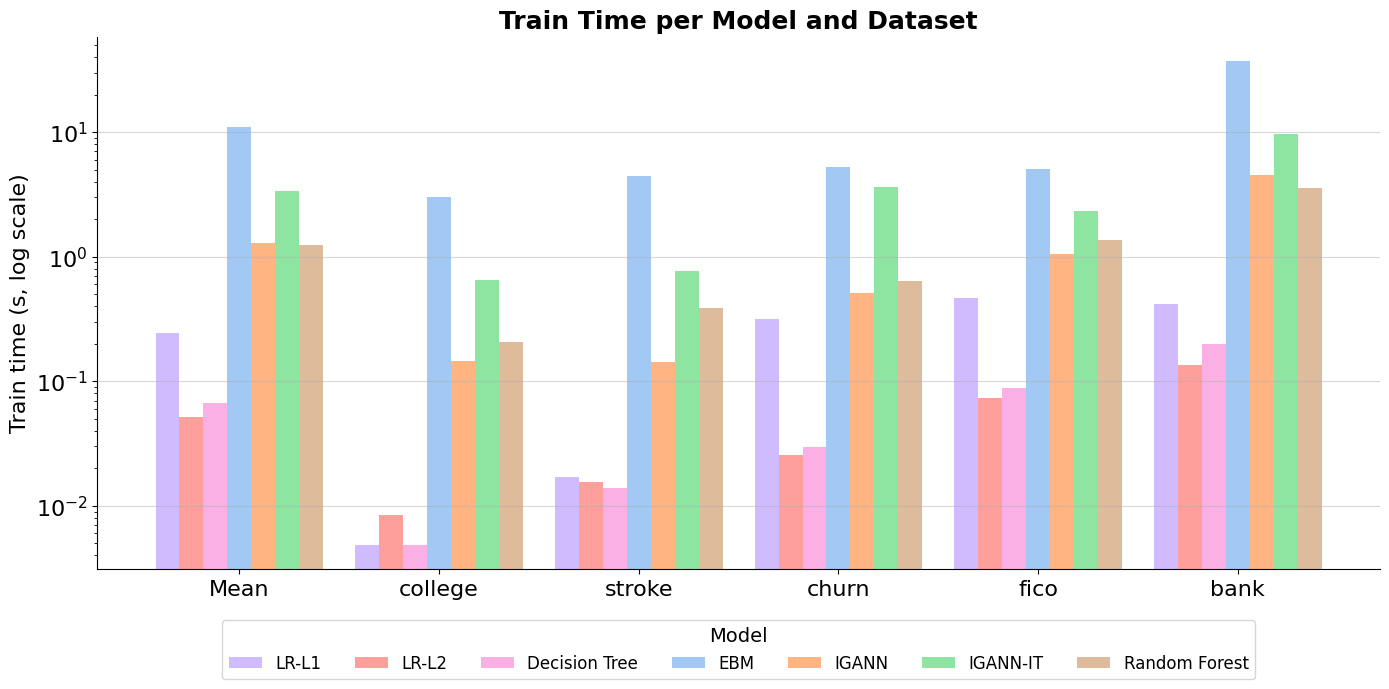

In [42]:
# Use seaborn pastel palette
#pastel_colors = sns.color_palette("pastel", len(train_time_df.index))
custom_colors = {
    'LR-L1': '#d0bbff',
    'LR-L2': '#ff9f9b',
    'Decision Tree': '#fab0e4',
    'EBM': '#a1c9f4',
    'IGANN': '#ffb482',
    'IGANN-IT': '#8de5a1',
    'Random Forest': '#debb9b'
}
bar_width = 0.12
x = np.arange(len(train_time_df.columns)) 

# Plot setup with pastel colors
fig, ax = plt.subplots(figsize=(14, 7))

# Plot each model's bars using pastel colors
for i, model in enumerate(train_time_df.index):
    times = train_time_df.loc[model]
    ax.bar(x + i * bar_width, times, width=bar_width, label=model, color=custom_colors[model])

# Axes and formatting
ax.set_yscale("log")
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Train time (s, log scale)", fontsize=16)
ax.set_xticks(x + bar_width * (len(train_time_df.index) - 1) / 2)
ax.set_xticklabels(train_time_df.columns, fontsize=16)
ax.set_title("Train Time per Model and Dataset", fontsize=18, fontweight='semibold')
ax.legend(
    title="Model",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.08),  # x=0.5 → zentriert, y negativ → unterhalb
    ncol=len(train_time_df.index),      # alle Einträge in einer Zeile
    frameon=True,
    fontsize=12,
    title_fontsize=14,
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, axis='y', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()